In [4]:
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns

# yfinance is used to fetch data
import yfinance as yf
import datetime as dt
import warnings
warnings.simplefilter("ignore")

[*********************100%%**********************]  1 of 1 completed


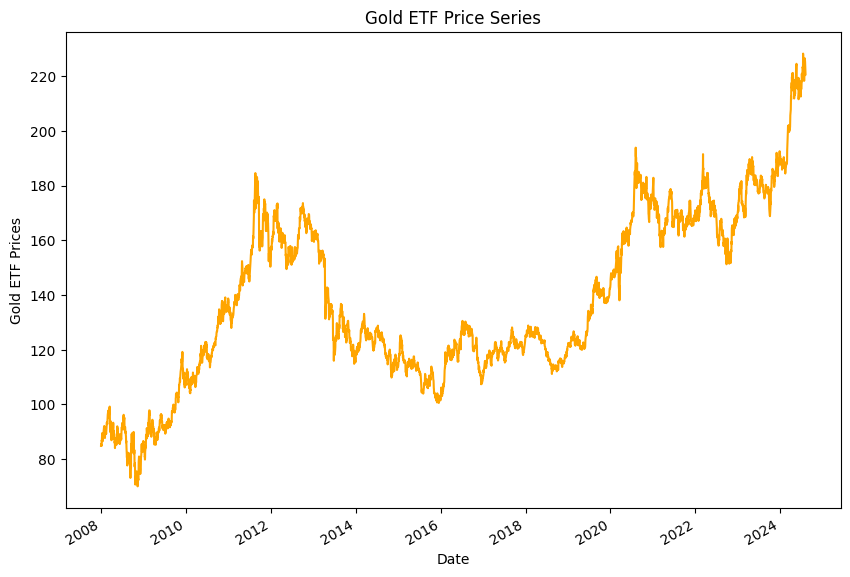

In [5]:
# Read data
df = yf.download('GLD', '2008-01-01', '2024-08-07', auto_adjust=True)

# Only keep close columns
df = df[['Close']]

# Drop rows with missing values
df = df.dropna()

# Plot the closing price of GLD
df.Close.plot(figsize=(10, 7),color='orange')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

In [6]:
# Define explanatory variables
df['S_3'] = df['Close'].rolling(window=5).mean()
df['S_9'] = df['Close'].rolling(window=30).mean()
df['next_day_price'] = df['Close'].shift(-1)

df = df.dropna()
X = df[['S_3', 'S_9']]

# Define dependent variable
y = df['next_day_price']

In [7]:
# Split the data into train and test dataset
t = .8
t = int(t*len(df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold ETF Price (y) = %.2f * 5 Days Moving Average (x1) \
+ %.2f * 30 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
Gold ETF Price (y) = 1.07 * 5 Days Moving Average (x1) + -0.08 * 30 Days Moving Average (x2) + 0.49 (constant)


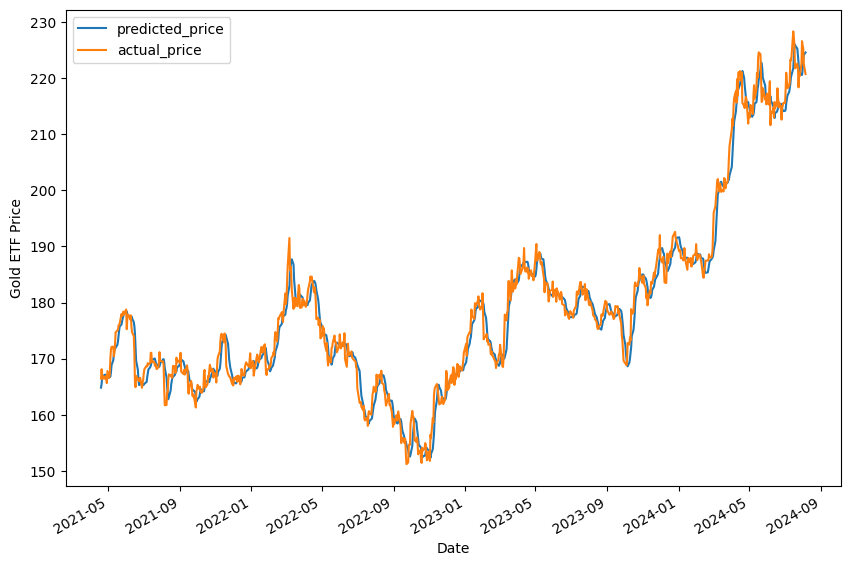

98.05

In [8]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

In [9]:
gold = pd.DataFrame()

gold['price'] = df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)
gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)
gold.head()

,price,predicted_price_next_day,actual_price_next_day,gold_returns,signal
Date,,,,,
2021-04-19,165.889999,164.852498,166.479996,0.003557,0
2021-04-20,166.479996,165.484300,168.130005,0.009911,1
2021-04-21,168.130005,166.627219,167.039993,-0.006483,1
2021-04-22,167.039993,166.976271,166.399994,-0.003831,1
2021-04-23,166.399994,166.974462,166.839996,0.002644,0


In [10]:
gold['actual_price_next_day'] = gold.price.shift(-1)
gold['actual_signal'] = np.where(gold.actual_price_next_day.shift(1) < gold.actual_price_next_day,1,0)
gold.tail()

,price,predicted_price_next_day,actual_price_next_day,gold_returns,signal,actual_signal
Date,,,,,,
2024-07-30,222.520004,220.540864,226.550003,0.018111,0,1
2024-07-31,226.550003,221.530113,225.770004,-0.003443,1,0
2024-08-01,225.770004,223.101185,225.339996,-0.001905,1,0
2024-08-02,225.339996,224.094078,222.479996,-0.012692,1,0
2024-08-05,222.479996,224.538088,NaN,NaN,1,0


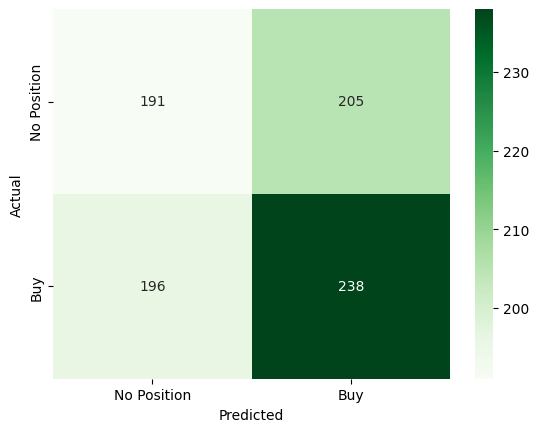

In [11]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(gold['actual_signal'], gold['signal'])
pf = pd.DataFrame(array, index = ['No Position','Buy'], columns = ['No Position','Buy'])

# Plot the heatmap
import seaborn as sns
sns.heatmap(pf, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [12]:
from sklearn.metrics import classification_report
print(classification_report(gold['actual_signal'], gold['signal'], target_names=['No Position','Buy']))

              precision    recall  f1-score   support

 No Position       0.49      0.48      0.49       396
         Buy       0.54      0.55      0.54       434

    accuracy                           0.52       830
   macro avg       0.52      0.52      0.52       830
weighted avg       0.52      0.52      0.52       830



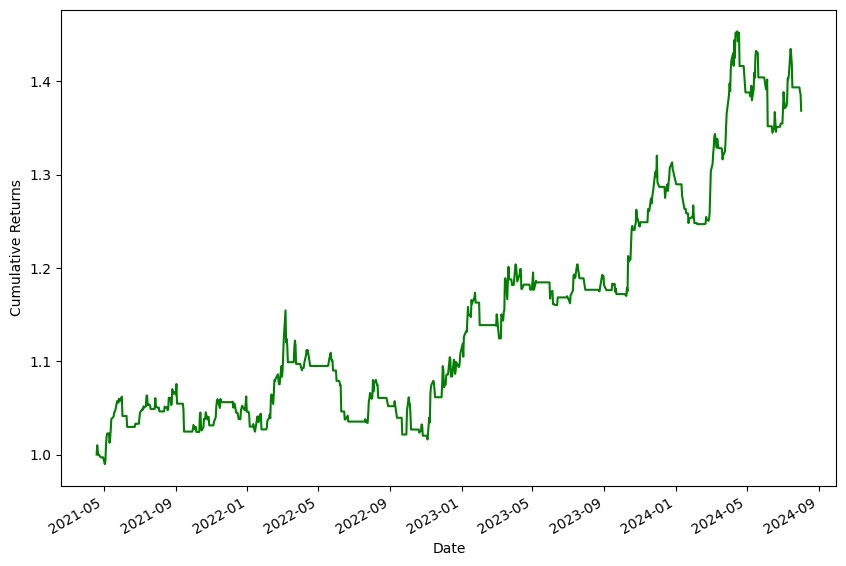

In [13]:
gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

In [14]:
'Sharpe Ratio %.2f' % (gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5))

'Sharpe Ratio 0.93'

In [15]:
import datetime as dt
current_date = dt.datetime.now()
data = yf.download('GLD', '2008-06-01', '2024-08-07', auto_adjust=True)
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()
data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")
data.tail(1)[['signal','predicted_gold_price']].T

[*********************100%%**********************]  1 of 1 completed


Date,2024-08-06
signal,No Position
predicted_gold_price,222.579655
